# 1 - Training a Random Forest Model
---------------
This notebooks will train a Random Forest Classifier to predict whether a given song is likely to be "liked" based on other playlists in the list.

In [1]:
import pickle as pkl
from typing import Iterable, Union

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn import tree
import graphviz

# Custom packages
import helpers as h
from helpers import Playlist

In [2]:
## Import data
# Two playlists with very different vibes
# https://open.spotify.com/playlist/5Os91wBXvZCdwiOa2aJV5I?si=22eadc4636634b6d
rb_playlist_id = '5Os91wBXvZCdwiOa2aJV5I'
rb_playlist = Playlist(rb_playlist_id)

# https://open.spotify.com/playlist/2q4kES8D0GmKOJx4Uqvliv?si=dfb36f6a589f4335
lnv_playlist_id = '2q4kES8D0GmKOJx4Uqvliv'
lnv_playlist = Playlist(lnv_playlist_id)


In [3]:
class PlaylistCluster():
    '''A class to make combining playlists easier for machine learning.'''

    def __init__(self, playlists:Iterable):
        # type checking raw input
        self.playlist_list = []
        for pl in playlists:
            if isinstance(pl, Playlist):
                self.playlist_list.append(pl)

        self.refresh_playlists_list()
        
    def refresh_playlists_list(self):
        self.data = pd.concat([pl.data for pl in self.playlist_list])
        self.ml_data = pd.concat([pl.ml_data for pl in self.playlist_list])
        self.ml_likes = pd.concat([pl.ml_likes for pl in self.playlist_list])
        self.nsongs = self.ml_data.shape[0]

    def set_playlist_likes(self, nplaylist:int, likes:Union[int, Iterable]):
        self.playlist_list[nplaylist].set_like_status(likes)
        self.refresh_playlists_list()

In [4]:
PLC = PlaylistCluster([rb_playlist, lnv_playlist])
PLC.nsongs

51

In [5]:
PLC.set_playlist_likes(0, 1) # Like songs from the first playlist
PLC.set_playlist_likes(1, 0) # Dislike songs from the second playlist
PLC.ml_data

,,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,name,,,,,,,,,,,,,
5awNIWVrh2ISfvPd5IUZNh,PTT (Paint The Town),0.07350,0.781,201120,0.814,0.000019,8,0.0565,-2.437,1,0.1000,124.028,4,0.5460
65497v9jzFfu5sSA8ADap5,Sistema De Patio,0.07000,0.914,134223,0.948,0.000782,6,0.3280,-2.243,0,0.2100,109.999,4,0.6940
7I0vl97TYZW86qYdgcD1qu,Back Door,0.15700,0.820,189287,0.842,0.000000,7,0.1120,-3.853,1,0.2720,107.952,4,0.6530
7dMTCS9BLzBqYTlAuHP8TM,XT4S1S,0.10100,0.797,219320,0.677,0.000000,9,0.4410,-4.163,0,0.0857,130.034,4,0.9190
0Z99Xe1lGBmq60RwJ5YU18,PING PONG,0.01220,0.855,158253,0.870,0.000675,10,0.0202,-2.059,0,0.0826,103.028,4,0.8630
1t8sqIScEIP0B4bQzBuI2P,MY BAG,0.08640,0.838,160520,0.823,0.000071,8,0.1560,-3.929,0,0.1640,94.024,4,0.7590
0bspC5fLlWgwCM6Rx1YUIh,BIG MAD,0.02930,0.958,143111,0.523,0.000000,8,0.1060,-6.100,1,0.0591,102.039,4,0.3090
7gRFDGEzF9UkBV233yv2dc,Shut Down,0.00327,0.818,175889,0.690,0.000000,0,0.1860,-5.119,1,0.0454,110.071,3,0.6880
4kXxEhuatrvwrTQycA7s9B,BIZCOCHITO,0.60500,0.930,109120,0.774,0.023800,1,0.1200,-4.203,1,0.0744,116.972,4,0.7810


In [6]:
X = PLC.ml_data.loc[:, PLC.ml_data.columns != 'like']
y = PLC.ml_likes['like']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
rf_clf = RandomForestClassifier(n_estimators=6, max_depth=2)
rf_clf.fit(X_train , y_train)
y_preds_rf = rf_clf.predict(X_test)
print("Accuracy Score of the Random Forest Model", accuracy_score(y_test, y_preds_rf))
print("ROC AUC Score of the Random Forest Model", roc_auc_score(y_test, y_preds_rf))

Accuracy Score of the Random Forest Model 0.9375
ROC AUC Score of the Random Forest Model 0.9375


In [9]:
rf_clf.estimators_

[DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=990567980),
 DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                        random_state=1568810598),
 DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                        random_state=1496343530),
 DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                        random_state=1278605927),
 DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                        random_state=1323915396),
 DecisionTreeClassifier(max_depth=2, max_features='sqrt',
                        random_state=2147476735)]

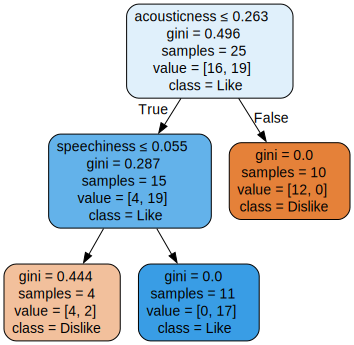

In [17]:
# There will be 6 trees in this random forest.
# Select the index for visualizations.
ind = 5
dot_data = tree.export_graphviz(rf_clf.estimators_[ind], out_file=None)
graph = graphviz.Source(dot_data)
graph.render('Liked')
dot_data = tree.export_graphviz(rf_clf.estimators_[ind], out_file=None,
                                feature_names=list(X.columns),
                                class_names=['Dislike', 'Like'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data, format='png')
graph

In [11]:
# Export the trained model as a .pkl file so that it can be uploaded to the next Jupyter notebook
with open('./trained_rf.pkl', 'wb') as f:
    pkl.dump(rf_clf, f)

In [12]:
# Let's save the playlist cluster as well
with open('./playlist_cluster.pkl', 'wb') as f:
    pkl.dump(PLC, f)